<a href="https://colab.research.google.com/github/philipp-lampert/mymandible/blob/main/data_science/02_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the data exploration and visualization notebook

In [155]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's first import the processed dataframe from GitHub.

In [156]:
local_directory = "/root/mymandible"
%cd

if os.path.exists(local_directory):
  os.chdir(local_directory)
  ! git pull
  %cd data_science/data

else:
  ! git clone https://github.com/philipp-lampert/mymandible
  %cd mymandible/data_science/data

df = pd.read_parquet('mymandible.parquet')

/root
Already up to date.
/root/mymandible/data_science/data


We will start by creating some graphs to get a sense of what our patient collective looks like.

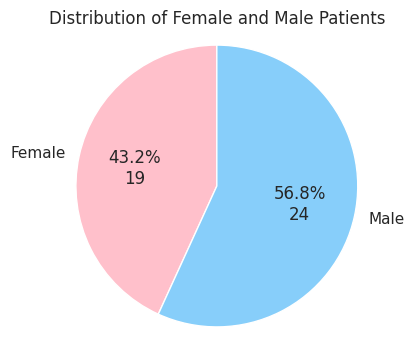

In [190]:
female_count = df['sex_female'].sum()
male_count = len(df) - female_count

labels = ['Female', 'Male']
sizes = [female_count, male_count]
colors = ['pink', 'lightskyblue']

# Calculate total count
total_count = sum(sizes)

# Create a pie chart with both percentage and absolute number
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct=lambda p: f'{p:.1f}%\n{int(total_count * p / 100)}', startangle=90)
plt.title('Distribution of Female and Male Patients')
plt.axis('equal')
plt.show()

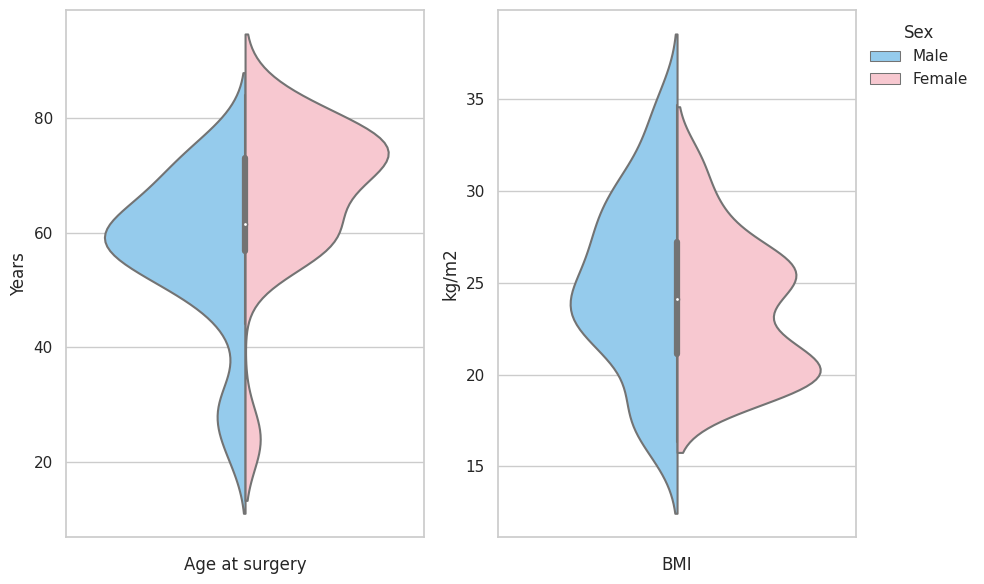

In [187]:
colors = ['lightskyblue', 'pink']
df['all'] = ''

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)

bw = 0.4

sns.violinplot(x=df['all'], y=df['age_surgery_years'].astype('int'), palette=colors, hue=df['sex_female'], split = True, bw=bw)
plt.legend([], frameon=False)

plt.xlabel('Age at surgery')
plt.ylabel('Years')
plt.title('')

plt.subplot(1, 2, 2)
ax = sns.violinplot(x=df['all'], y=df['bmi'].astype('float'), hue=df['sex_female'], palette=colors, split=True, bw=bw)

handles, labels = ax.get_legend_handles_labels()
labels = ["Male", "Female"]
ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(1, 1), title = 'Sex', frameon=False)

plt.xlabel('BMI')
plt.ylabel('kg/m2')
plt.title('')

plt.tight_layout()
plt.show()

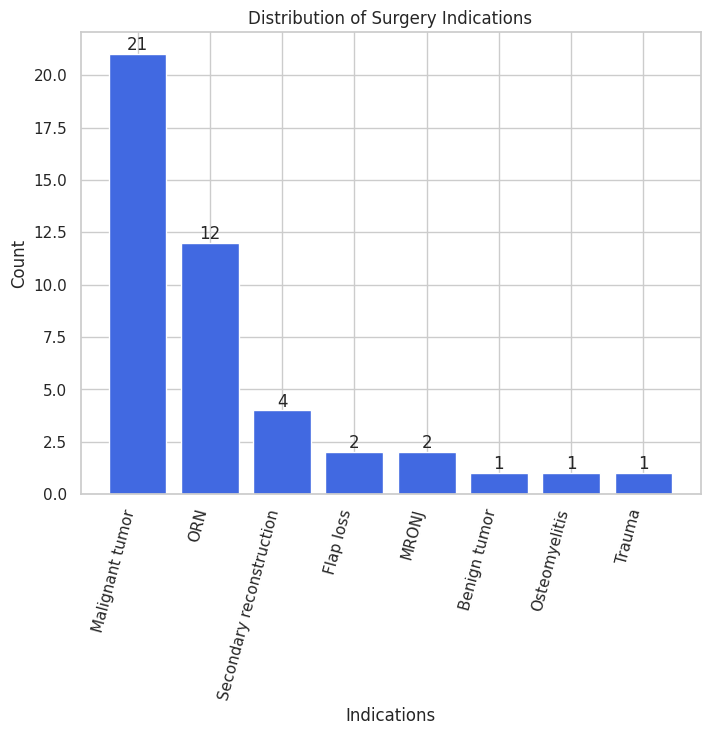

In [192]:
indication_counts = df['indication'].value_counts()
indication_counts = indication_counts.sort_values(ascending=False)

labels = {
    'malignant_tumor': 'Malignant tumor',
    'benign_tumor': 'Benign tumor',
    'osteoradionecrosis': 'ORN',
    'secondary_reconstruction': 'Secondary reconstruction',
    'flap_loss': 'Flap loss',
    'medication_related_osteonecrosis': 'MRONJ',
    'osteomyelitis': 'Osteomyelitis',
    'trauma': 'Trauma'
}

indication_counts = indication_counts.rename(labels)
labels = indication_counts.index
sizes = indication_counts.values

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color = 'royalblue')

# Add data labels
for i in range(len(labels)):
    plt.text(i, sizes[i], sizes[i], ha='center', va='bottom')

plt.xlabel('Indications')
plt.ylabel('Count')
plt.title('Distribution of Surgery Indications')
plt.xticks(rotation=75, ha='right')
plt.show()

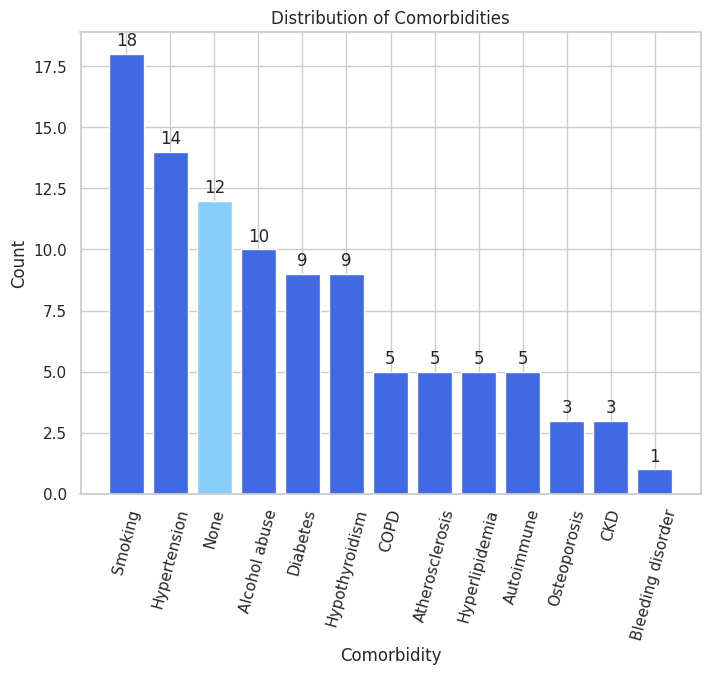

In [160]:
comorbidity_counts = {}

# Calculate counts for comorbidity columns
for column in df.columns:
    if "comorbidity___" in column:
        comorbidity_option = column.replace('comorbidity___', '')
        comorbidity_counts[comorbidity_option] = df[column].sum()

comorbidity_df = pd.DataFrame(list(comorbidity_counts.items()), columns=['Comorbidity', 'Count'])
comorbidity_df = comorbidity_df.sort_values(by='Count', ascending=False)

labels = {
    'smoking': 'Smoking',
    'hypertension': 'Hypertension',
    'none': 'None',
    'alcohol': 'Alcohol abuse',
    'diabetes': 'Diabetes',
    'hypothyroidism': 'Hypothyroidism',
    'copd': 'COPD',
    'atherosclerosis': 'Atherosclerosis',
    'hyperlipidemia': 'Hyperlipidemia',
    'autoimmune_disease': 'Autoimmune',
    'osteoporosis': 'Osteoporosis',
    'chronic_kidney_disease': 'CKD',
    'bleeding_disorder': 'Bleeding disorder'
}
comorbidity_df['Comorbidity'] = comorbidity_df['Comorbidity'].map(labels).fillna(comorbidity_df['Comorbidity'])

colors = ['lightskyblue' if comorbidity == 'None' else 'royalblue' for comorbidity in comorbidity_df['Comorbidity']]

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(comorbidity_df['Comorbidity'], comorbidity_df['Count'], color=colors)
plt.title('Distribution of Comorbidities')
plt.xlabel('Comorbidity')
plt.ylabel('Count')
plt.xticks(rotation=75)  # Rotate x-axis labels for better visibility

# Annotate each bar with its absolute number
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords='offset points', ha='center', va='bottom')

plt.show()

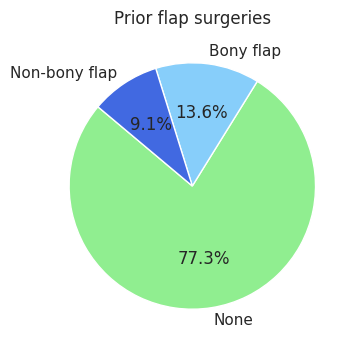

In [161]:
flap_counts = df['prior_flap'].value_counts()

sizes = flap_counts.values
colors = ['lightgreen', 'lightskyblue', 'royalblue']

labels = {
    'none': 'None',
    'bony': 'Bony flap',
    'non_bony': 'Non-bony flap',
}

flap_counts = flap_counts.rename(labels)
labels = flap_counts.index

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Prior flap surgeries')
plt.show()

In [162]:
df.columns.values

array(['sex_female', 'indication', 'comorbidity___none',
       'comorbidity___smoking', 'comorbidity___alcohol',
       'comorbidity___copd', 'comorbidity___hypertension',
       'comorbidity___diabetes', 'comorbidity___atherosclerosis',
       'comorbidity___hyperlipidemia', 'comorbidity___osteoporosis',
       'comorbidity___hypothyroidism',
       'comorbidity___chronic_kidney_disease',
       'comorbidity___bleeding_disorder',
       'comorbidity___autoimmune_disease', 'which_autoimmune_disease',
       'which_bleeding_disorder', 'prior_flap', 'age_surgery_years',
       'flap_donor_site', 'flap_revision', 'days_to_flap_revision',
       'radiotherapy___none', 'radiotherapy___pre_surgery',
       'radiotherapy___post_surgery', 'chemotherapy___none',
       'chemotherapy___pre_surgery', 'chemotherapy___post_surgery',
       'plate_type', 'long_plate_thickness', 'urkens_classification___c',
       'urkens_classification___r', 'urkens_classification___b',
       'urkens_classificatio